In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline

# some pandas options
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

pd.set_option("display.expand_frame_repr", False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

# Silent payment transaction scanning

A light client needs tweak data for every transaction mined since its last scan which has at least one unspent taproot output. They can also skip transactions which do not have any silent payment eligible inputs, but considering the number is negligible, we are ignoring it for now to keep things simple.

To simulate this scanning, we get the block height when each taproot output was created, and the block height when it is later spent. Next, group by txid and take the max spent block height. This gives us a range of blocks for each silent payments eligible transaction.

In [ ]:
%%bigquery vintage_per_taproot_output
SELECT block_timestamp, created, spent, spent - created AS vintage FROM (
SELECT block_timestamp
     , transaction_hash
     , created
     , MAX(spent) as spent 
  FROM
(
SELECT o.transaction_hash
     , o.block_timestamp
     , o.block_number as created
     , i.block_number as spent
  FROM `bigquery-public-data.crypto_bitcoin.outputs` o 
  LEFT JOIN `bigquery-public-data.crypto_bitcoin.inputs` i 
         ON o.transaction_hash = i.spent_transaction_hash 
        AND o.index = i.spent_output_index
      WHERE o.type = "witness_v1_taproot"
        AND o.block_timestamp >= "2023-01-01"
        AND o.block_timestamp <  "2023-06-01"
) GROUP BY 1,2,3)
;

In [23]:
min_block = vintage_per_taproot_output['created'].min()
max_block = vintage_per_taproot_output['created'].max()
# vintage_per_taproot_output.to_csv(f'vintage_per_taproot_output_{min_block}_to_{max_block}.csv', index=False)

In [2]:
vintage_per_taproot_output = pd.read_csv('vintage_per_taproot_output_769787_to_792316.csv')

## Transaction cut-through

Now that we have a range for how long a transaction has at least one unspent taproot output, we can see that 75% of transactions spend all of their taproot outputs in 326 blocks or less. This means by scanning less frequently, we can avoid downloading data on transactions which are clearly not payments to us.

In [18]:
with pd.option_context('float_format', '{:0.0f}'.format):
    print(vintage_per_taproot_output['vintage'].describe())

count   5686159
mean        637
std        1774
min           0
25%           1
50%          19
75%         326
max       23120
Name: vintage, dtype: float64


## Scanning frequency

If we can assume that a mobile user (and in particular, a mobile user who does not run their own bitcoin node) does not open their Bitcoin wallet multiple times per day, then scanning every three days, once a week, or even once a month seems more reasonable. This would allow the user to significantly cut down on the data needed.

For silent payment mobile wallets, one can imagine a client where opportunistic notifacitions are sent, and then the client falls back to scanning once a month just to make sure everything is in order.

In [20]:
block_intervals = vintage_per_taproot_output.groupby(
    ['block_timestamp','created','spent']
).count()
bi_df = block_intervals.reset_index().sort_values(by='created')

In [29]:
bi_df['block_timestamp'] = pd.to_datetime(bi_df['block_timestamp'])

In [30]:
def sum_txs(group_range, df):
    df['block_timestamp_scan'] = df['block_timestamp'].max()
    return df.groupby(
        df['block_timestamp_scan']
    ).apply(lambda x: x[x['spent'] > group_range.right]['vintage'].sum() * 32 * 0.000001)

In [39]:
start = min_block
end = max_block

interval = 10
scans = list(range(start, end, interval))
groups = bi_df.groupby(pd.cut(bi_df['created'], scans))
results = bi_df.groupby(
    pd.cut(bi_df['created'], scans)
).apply(lambda x: sum_txs(x.name, x)).reset_index(name='scanned_mbs')[['block_timestamp_scan', 'scanned_mbs']]
every_10_blocks = results.set_index('block_timestamp_scan').rename(columns={'scanned_mbs': '10 blocks'})

# once every 144 blocks
interval = 144
scans = list(range(start, end, interval))
groups = bi_df.groupby(pd.cut(bi_df['created'], scans))
results = bi_df.groupby(
    pd.cut(bi_df['created'], scans)
).apply(lambda x: sum_txs(x.name, x)).reset_index(name='scanned_mbs')[['block_timestamp_scan', 'scanned_mbs']]
once_per_day = results.set_index('block_timestamp_scan').rename(columns={'scanned_mbs': 'daily'})

# once every 3 days
interval = 144 * 3
scans = list(range(start, end, interval))
groups = bi_df.groupby(pd.cut(bi_df['created'], scans))
results = bi_df.groupby(
    pd.cut(bi_df['created'], scans)
).apply(lambda x: sum_txs(x.name, x)).reset_index(name='scanned_mbs')[['block_timestamp_scan', 'scanned_mbs']]
every_three_days = results.set_index('block_timestamp_scan').rename(columns={'scanned_mbs': 'three days'})

# once every week 
interval = 144 * 7
scans = list(range(start, end, interval))
groups = bi_df.groupby(pd.cut(bi_df['created'], scans))
results = bi_df.groupby(
    pd.cut(bi_df['created'], scans)
).apply(lambda x: sum_txs(x.name, x)).reset_index(name='scanned_mbs')[['block_timestamp_scan', 'scanned_mbs']]
once_per_week = results.set_index('block_timestamp_scan').rename(columns={'scanned_mbs': 'weekly'})

# once every month
interval = 144 * 30
scans = list(range(start, end, interval))
groups = bi_df.groupby(pd.cut(bi_df['created'], scans))
results = bi_df.groupby(
    pd.cut(bi_df['created'], scans)
).apply(lambda x: sum_txs(x.name, x)).reset_index(name='scanned_mbs')[['block_timestamp_scan', 'scanned_mbs']]
once_per_month = results.set_index('block_timestamp_scan').rename(columns={'scanned_mbs': 'monthly'})

Text(0.5, 1.0, 'Scan data downloaded (MBs per month)')

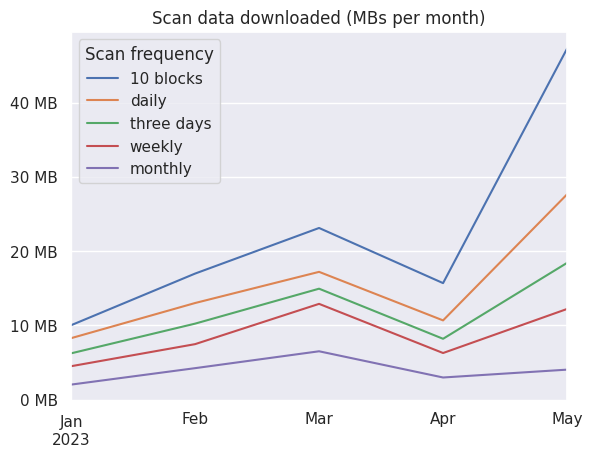

In [46]:
ax1 = every_10_blocks.groupby(pd.Grouper(freq='M')).sum().plot()
once_per_day.groupby(pd.Grouper(freq='M')).sum().plot(ax=ax1)
every_three_days.groupby(pd.Grouper(freq='M')).sum().plot(ax=ax1)
once_per_week.groupby(pd.Grouper(freq='M')).sum().plot(ax=ax1)
once_per_month.groupby(pd.Grouper(freq='M')).sum().plot(ax=ax1)
ax1.legend(title='Scan frequency')

from matplotlib.ticker import FormatStrFormatter

ax1.yaxis.set_major_formatter(FormatStrFormatter('%d MB'))
ax1.xaxis.label.set_visible(False)
ax1.set_title('Scan data downloaded (MBs per month)')